In [31]:
import s3fs
import os
from nnunetv2.dataset_conversion.generate_dataset_json import generate_dataset_json
from tqdm import tqdm
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.cm as cm

s3 = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'},
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"],
    token=os.environ["AWS_SESSION_TOKEN"]
)

In [2]:
root = "leoacpr/diffusion/"
prefix = "UKCHLL"

ids = []

for path in s3.ls(root):
    folder = path.split(root)[1]
    if prefix in folder: ids.append(folder)

ids

['UKCHLL001',
 'UKCHLL002',
 'UKCHLL009',
 'UKCHLL011',
 'UKCHLL015',
 'UKCHLL017',
 'UKCHLL021',
 'UKCHLL023',
 'UKCHLL031',
 'UKCHLL034',
 'UKCHLL035',
 'UKCHLL037',
 'UKCHLL038',
 'UKCHLL039',
 'UKCHLL041',
 'UKCHLL042',
 'UKCHLL043',
 'UKCHLL045',
 'UKCHLL046',
 'UKCHLL048']

In [3]:
for i in tqdm(["1", "2", "3"], desc="Téléchargement des images"):
    s3.get(root + ids[0] + "/annotation_" + i + ".nii.gz", "test/CURVAS_" + ids[0] + "_annotation_" + i + ".nii.gz")

s3.get(root + ids[0] + "/image.nii.gz", "test/CURVAS_" + ids[0] + "_image.nii.gz")

Téléchargement des images: 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]


[None]

In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Charger les 3 annotations
anno1 = nib.load(f"test/CURVAS_{ids[0]}_annotation_1.nii.gz").get_fdata()
anno2 = nib.load(f"test/CURVAS_{ids[0]}_annotation_2.nii.gz").get_fdata()
anno3 = nib.load(f"test/CURVAS_{ids[0]}_annotation_3.nii.gz").get_fdata()
annos_data = [anno1, anno2, anno3]

# Charger l'image CT
ct_data = nib.load(f"test/CURVAS_{ids[0]}_image.nii.gz").get_fdata()

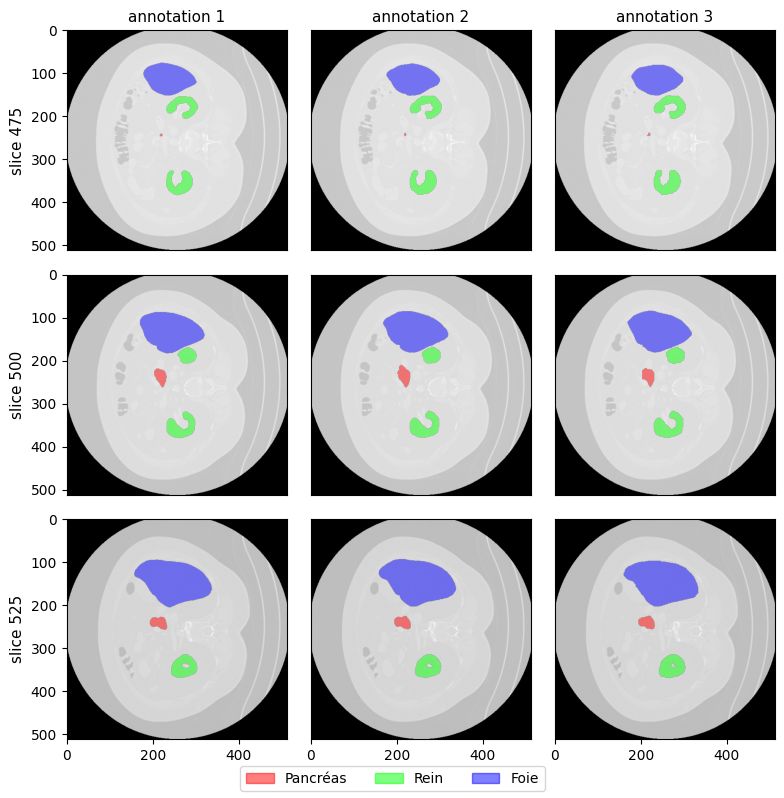

In [5]:
colors = {
    "Pancréas": [1.0, 0.0, 0.0, 0.5],
    "Rein": [0.0, 1.0, 0.0, 0.5],
    "Foie": [0.0, 0.0, 1.0, 0.5],
}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

## désolé pour le code moche il est tard :(
## c pas très important mais au moins on a un truc un peu visuel
for i, slice_idx in enumerate([475, 500, 525]):
    for j, anno_data in enumerate(annos_data):
        ax = axes[i, j]
        slice_ct = ct_data[:, :, slice_idx]
        ax.imshow(slice_ct, cmap='gray')
        overlay = np.zeros(slice_ct.shape + (4,), dtype=np.float32)
        for k, l in enumerate(colors):
            mask = (anno_data[:, :, slice_idx] > k + 0.9) & (anno_data[:, :, slice_idx] < k + 1.1)
            overlay[mask] = colors[l]
        ax.imshow(overlay)
        ax.axis('image')
        if i == 0: ax.set_title(f"annotation {j+1}", fontsize=11)
        if j == 0: ax.set_ylabel(f"slice {slice_idx}", fontsize=11)
        else: ax.get_yaxis().set_visible(False)
        if i != 2: ax.get_xaxis().set_visible(False)

fig.tight_layout()
plt.subplots_adjust(bottom=0.07)
fig.legend(handles=[mpatches.Patch(color=c, label=l) for l, c in colors.items()], loc='lower center', ncol=3)

In [7]:
fig.savefig("figure_UKCHLL001.pdf")
fig.savefig("figure_UKCHLL001.png")

In [6]:
# Charger les annotations
anno1 = nib.load(f"test/CURVAS_{ids[0]}_annotation_1.nii.gz").get_fdata()
anno2 = nib.load(f"test/CURVAS_{ids[0]}_annotation_2.nii.gz").get_fdata()
anno3 = nib.load(f"test/CURVAS_{ids[0]}_annotation_3.nii.gz").get_fdata()

# Empiler les annotations pour obtenir un tableau de forme (3, H, W, D)
annotations = np.stack([anno1, anno2, anno3], axis=0)
annotations_int = np.rint(annotations).astype(np.int8)

In [9]:
num_classes = 4 #(fond: 0, pancréas: 1, rein:2, foie: 3)
shape = anno1.shape  # shape (H, W, D)

# tableau pour les soft labels de forme (num_classes, H, W, D)
soft_labels = np.zeros((num_classes,) + shape, dtype=np.float32)

# Pour chaque label, on calcule la moyenne des masques one-hot
for i in range(4):
    mask = (annotations_int == i).astype(np.float32)  # shape (3, H, W, D)
    soft_labels[i] = np.mean(mask, axis=0)

### Explication de <insérer LLM préféré> :

La matrice affine est essentielle dans une image NIfTI car elle définit la transformation qui permet de convertir les indices de voxel (les coordonnées de la matrice)
en coordonnées du monde réel (par exemple, en millimètres). Cela inclut des informations sur :
- La position de l'image dans l'espace.
- L'orientation de l'image (comment l'image est tournée).
- L'échelle (la taille des voxels).

On peut la récupérer dans l'image de base, et pour l'opti ça devrait être la même sur chaque image (ça pourrait être utile parce que c'est bien long de charge chaque nii.gz surtout les images...)

**NOTE POUR L'OPTI FUTURE** : Il va falloir utiliser le garbage collector parce que sinon la RAM va exploser. Il y a un truc dans le repo CURVAS qui fait qqc de similaire, à aller check.

In [10]:
ct_img = nib.load(f"test/CURVAS_{ids[0]}_image.nii.gz")

# Créer une image Nifti avec les soft labels et l'affine de l'image CT
soft_labels_nii = nib.Nifti1Image(soft_labels, ct_img.affine)
nib.save(soft_labels_nii, f"test/CURVAS_{ids[0]}_annotation_soft_labels.nii.gz")

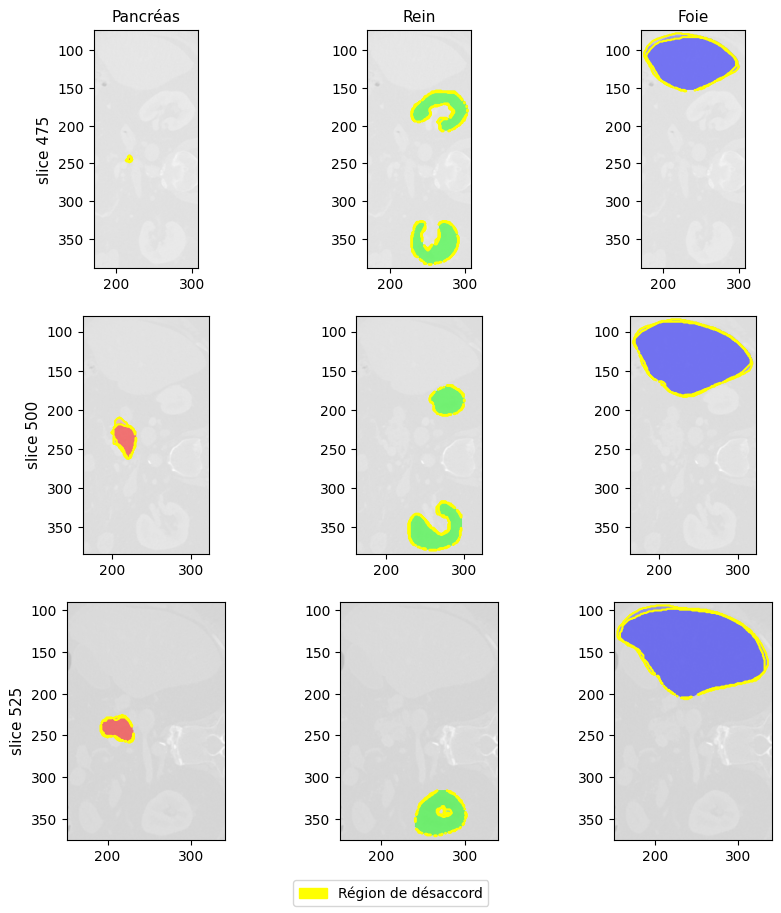

In [26]:
# Couleurs (RGBA) pour chaque organe
colors = {
    "Pancréas": [1.0, 0.0, 0.0, 0.5],
    "Rein":     [0.0, 1.0, 0.0, 0.5],
    "Foie":     [0.0, 0.0, 1.0, 0.5],
}

# Liste des organes avec leur indice dans soft_labels
organs = [("Pancréas", 1), ("Rein", 2), ("Foie", 3)]

# Définir les slices à afficher
slices = [475, 500, 525]

# Seuil pour considérer qu'un voxel appartient à la ROI (soft label > roi_thresh)
roi_thresh = 0.05
# Nombre de pixels de padding autour de la ROI
pad = 5

# Créer la figure : 3 lignes (slices) x 3 colonnes (organes)
fig, axes = plt.subplots(nrows=len(slices), ncols=len(organs), figsize=(10, 10))

for i, slice_idx in enumerate(slices):
    # Extraire la coupe CT correspondante
    slice_ct = ct_data[:, :, slice_idx]
    
    # Calculer l'union des soft labels pour les organes (excluant le fond)
    union_soft = np.maximum.reduce([
        soft_labels[1, :, :, slice_idx],
        soft_labels[2, :, :, slice_idx],
        soft_labels[3, :, :, slice_idx]
    ])
    # On crée un masque où la valeur du soft label est supérieure au seuil
    union_mask = union_soft > roi_thresh
    
    # Calculer la bounding box de cette union
    indices = np.argwhere(union_mask)
    if indices.size > 0:
        y_min, x_min = indices.min(axis=0)
        y_max, x_max = indices.max(axis=0)
        # Ajouter un padding tout en s'assurant de rester dans les dimensions de l'image
        roi_y_min = max(0, y_min - pad)
        roi_y_max = min(slice_ct.shape[0], y_max + pad)
        roi_x_min = max(0, x_min - pad)
        roi_x_max = min(slice_ct.shape[1], x_max + pad)
    else:
        # Si aucun soft label n'est détecté, on prend une ROI par défaut (zone centrale)
        H, W = slice_ct.shape
        roi_y_min, roi_y_max = H // 4, 3 * H // 4
        roi_x_min, roi_x_max = W // 4, 3 * W // 4

    for j, (organ_name, soft_idx) in enumerate(organs):
        ax = axes[i, j]
        # Afficher la coupe CT en niveaux de gris
        ax.imshow(slice_ct, cmap='gray')
        
        # Extraire le soft label pour l'organe
        soft_map = soft_labels[soft_idx, :, :, slice_idx]
        # Créer l'overlay coloré en fonction du soft label
        overlay = np.zeros(slice_ct.shape + (4,), dtype=np.float32)
        organ_color = colors[organ_name]
        overlay[..., 0] = organ_color[0]
        overlay[..., 1] = organ_color[1]
        overlay[..., 2] = organ_color[2]
        overlay[..., 3] = soft_map * organ_color[3]
        ax.imshow(overlay)
        
        # Mettre en valeur la zone de désaccord
        # On considère comme zone de désaccord les voxels dont le soft label est strictement entre 0 et 1
        tol = 0.01
        disagreement_mask = (soft_map > tol) & (soft_map < 1 - tol)
        ax.contour(disagreement_mask, levels=[0.5], colors='yellow', linewidths=1.5)
        
        # Appliquer le zoom en utilisant la ROI calculée dynamiquement
        ax.set_xlim(roi_x_min, roi_x_max)
        ax.set_ylim(roi_y_max, roi_y_min)  # Inversion pour imshow (origine en haut à gauche)
        
        # Titres et étiquettes
        if i == 0:
            ax.set_title(f"{organ_name}", fontsize=11)
        if j == 0:
            ax.set_ylabel(f"slice {slice_idx}", fontsize=11)

# Ajouter une légende globale indiquant que le contour jaune représente la zone de désaccord
legend_patch = mpatches.Patch(color='yellow', label='Région de désaccord')
plt.subplots_adjust(bottom=0.07)
fig.legend(handles=[legend_patch], loc='lower center', ncol=1)

In [27]:
fig.savefig("figure_UKCHLL001_disagree_region.pdf")
fig.savefig("figure_UKCHLL001_disagree_region.png")

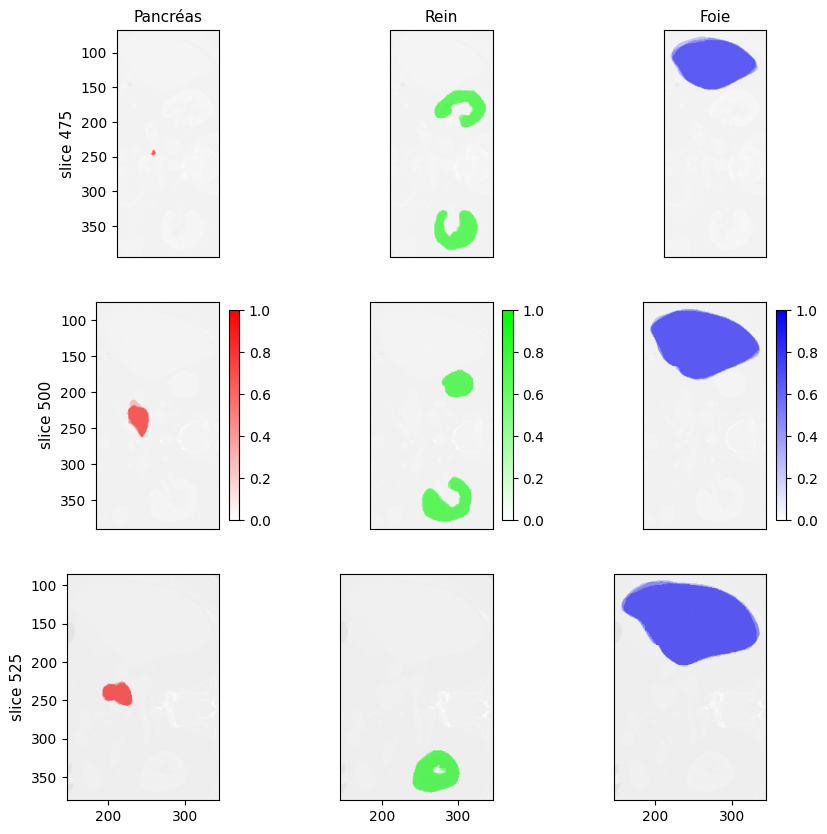

In [36]:
colors = {
    "Pancréas": [1.0, 0.0, 0.0],
    "Rein":     [0.0, 1.0, 0.0],
    "Foie":     [0.0, 0.0, 1.0],
}

# Liste des organes et leur indice dans soft_labels
organs = [("Pancréas", 1), ("Rein", 2), ("Foie", 3)]

# Choix de quelques slices à afficher
slices = [475, 500, 525]

# Seuil pour définir la ROI à partir de l'union des soft labels
roi_thresh = 0.05
# Padding autour de la ROI
pad = 10

# Création d'un colormap personnalisé pour chaque organe
custom_cmaps = {}
for organ_name in colors:
    organ_color = colors[organ_name]
    # Le colormap ira du blanc à la couleur de l'organe
    custom_cmaps[organ_name] = LinearSegmentedColormap.from_list(
        f"{organ_name}_cmap", [(1, 1, 1), tuple(organ_color)]
    )

# Création de la figure avec 3 lignes (slices) et 3 colonnes (organes)
fig, axes = plt.subplots(nrows=len(slices), ncols=len(organs), figsize=(10, 10))

for i, slice_idx in enumerate(slices):
    # Extraction de la coupe CT correspondante
    slice_ct = ct_data[:, :, slice_idx]
    
    # Calcul de l'union des soft labels (excluant le fond) pour définir la ROI
    union_soft = np.maximum.reduce([
        soft_labels[1, :, :, slice_idx],
        soft_labels[2, :, :, slice_idx],
        soft_labels[3, :, :, slice_idx]
    ])
    union_mask = union_soft > roi_thresh
    indices = np.argwhere(union_mask)
    if indices.size > 0:
        y_min, x_min = indices.min(axis=0)
        y_max, x_max = indices.max(axis=0)
        roi_y_min = max(0, y_min - pad)
        roi_y_max = min(slice_ct.shape[0], y_max + pad)
        roi_x_min = max(0, x_min - pad)
        roi_x_max = min(slice_ct.shape[1], x_max + pad)
    else:
        # Si aucune zone n'est détectée, on définit une ROI centrée
        H, W = slice_ct.shape
        roi_y_min, roi_y_max = H // 4, 3 * H // 4
        roi_x_min, roi_x_max = W // 4, 3 * W // 4

    for j, (organ_name, soft_idx) in enumerate(organs):
        ax = axes[i, j]
        # Affichage de la coupe CT en niveaux de gris
        ax.imshow(slice_ct, cmap='gray')
        
        # Extraction de la carte de soft values pour cet organe
        soft_map = soft_labels[soft_idx, :, :, slice_idx]
        
        # Affichage de la carte des soft values avec le colormap personnalisé et une transparence
        cmap = custom_cmaps[organ_name]
        im = ax.imshow(soft_map, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
        
        # Application du zoom sur la ROI calculée
        ax.set_xlim(roi_x_min, roi_x_max)
        ax.set_ylim(roi_y_max, roi_y_min)  # Inversion de l'axe y pour imshow
        
        # Titres et étiquettes
        if i == 0:
            ax.set_title(organ_name, fontsize=11)
        if j == 0:
            ax.set_ylabel(f"slice {slice_idx}", fontsize=11)
        else:
            ax.get_yaxis().set_visible(False)
        if i != len(slices) - 1:
            ax.get_xaxis().set_visible(False)

# Ajout d'une barre de couleur pour chaque colonne (organe)
for j, (organ_name, _) in enumerate(organs):
    cmap = custom_cmaps[organ_name]
    norm = Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    # Ajout de la colorbar à droite de la colonne j
    fig.colorbar(sm, ax=axes[:, j], orientation='vertical', fraction=0.046, pad=0.04)

In [37]:
fig.savefig("figure_UKCHLL001_soft_labels.pdf")
fig.savefig("figure_UKCHLL001_soft_labels.png")